In [47]:
import pandas as pd
import cv2
import os
import random
import numpy as np

In [54]:
# CONSTANTS
TRAIN_LABELS = '../data/labels/train_labels.csv'
TEST_LABELS = '../data/labels/test_labels.csv'
VAL_LABELS = '../data/labels/val_labels.csv'
LABELS = {"train": TRAIN_LABELS, "test": TEST_LABELS, "val": VAL_LABELS}

# CSV_FILE = '../data/labels/train_labels.csv'
IMG_DIR = "../data/bdd100k_images_100k/100k/train"
OUTPUT_DIR = 'data/'

PATCH_SIZE = (64, 128) # (Width, Height) - Standard HOG size
NUM_NEGATIVES_PER_IMG = 2 # How many background patches to crop per image

In [51]:
# Ensure output directories exist
classes = ['car', 'person', 'traffic sign', 'traffic light', 'background']
# classes = ['car', 'person', 'traffic sign', 'traffic light']
for (k, v) in LABELS.items():
    for cls in classes:
        os.makedirs(os.path.join(OUTPUT_DIR, k, cls), exist_ok=True)

In [40]:
def get_iou(boxA, boxB):
    # box = [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [41]:
def extract_patches(set_name, label_file):
    df = pd.read_csv(label_file)
    unique_images = df['image'].unique()

    print(len(unique_images))

    for img_name in unique_images:
        img_path = os.path.join(IMG_DIR, img_name+'.jpg')
        img = cv2.imread(img_path)
        
        if img is None: continue
        h, w, _ = img.shape
        
        img_objects = df[df['image'] == img_name]
        existing_boxes = []
        
        # Extracting object patches
        for idx, row in img_objects.iterrows():    
            cat = row['category']   
            x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
            
            # Clip to image boundaries
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            # Skip invalid small boxes
            if (x2 - x1) < 5 or (y2 - y1) < 5: continue
                
            existing_boxes.append([x1, y1, x2, y2])
            
            # Crop and Resize
            patch = img[y1:y2, x1:x2]
            try:
                # patch_resized = cv2.resize(patch, PATCH_SIZE)
                fname = f"{os.path.splitext(img_name)[0]}_{idx}.jpg"
                cv2.imwrite(os.path.join(OUTPUT_DIR, set_name,cat, fname), patch)
            except Exception as e:
                print(f"Skipping bad crop: {e}")

        # Extract background patches
        count = 0
        attempts = 0
        while count < NUM_NEGATIVES_PER_IMG and attempts < 20:
            attempts += 1
            
            # Random crop coordinates
            pw, ph = PATCH_SIZE
            if w < pw or h < ph: break # Image too small
                
            rnd_x = random.randint(0, w - pw)
            rnd_y = random.randint(0, h - ph)
            candidate_box = [rnd_x, rnd_y, rnd_x + pw, rnd_y + ph]
            
            # Check overlap with ANY object
            overlap = False
            for box in existing_boxes:
                if get_iou(candidate_box, box) > 0.05: # Strict threshold (5% overlap max)
                    overlap = True
                    break
            
            if not overlap:
                # Crop background
                bg_patch = img[rnd_y:rnd_y+ph, rnd_x:rnd_x+pw]
                # No resize needed if we cropped exactly PATCH_SIZE
                fname = f"{os.path.splitext(img_name)[0]}_neg_{count}.jpg"
                cv2.imwrite(os.path.join(OUTPUT_DIR, set_name, 'background', fname), bg_patch)
                count += 1

In [52]:
for (k, v) in LABELS.items():
    extract_patches(k, v)

7000
1000
2000


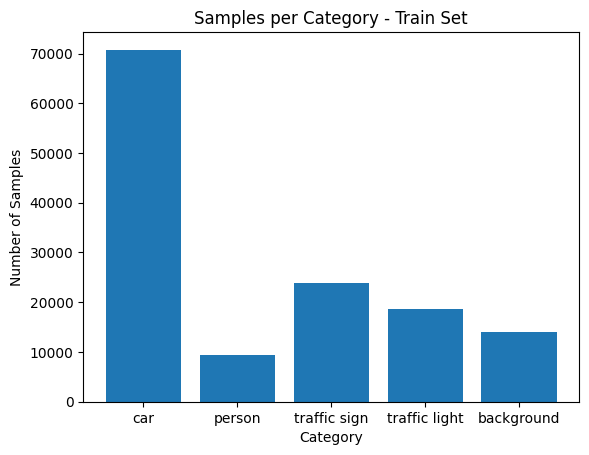

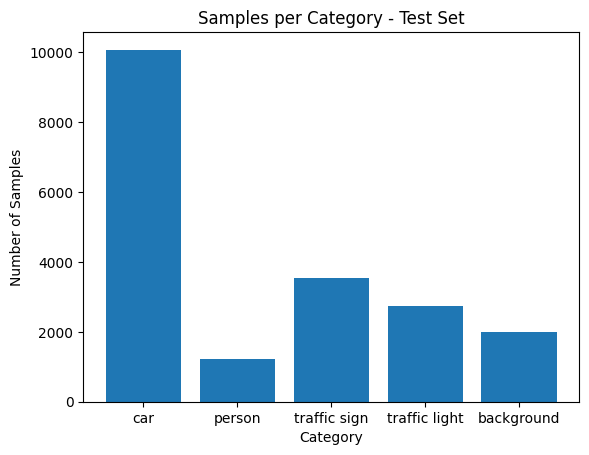

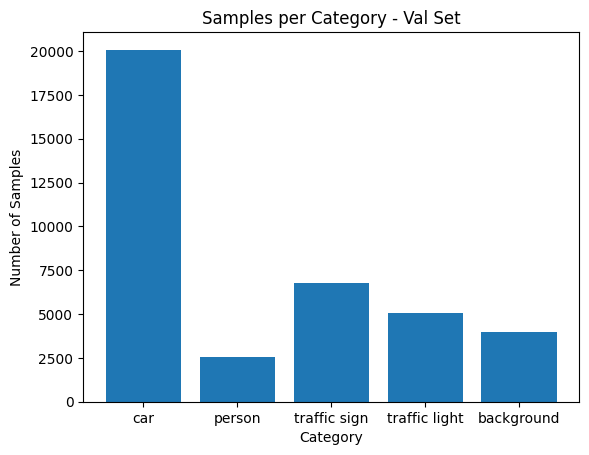

In [55]:
import matplotlib.pyplot as plt


for set_name in LABELS.keys():

    counts = {}
    for cls in classes[:-1]:  # Exclude 'background' as it's handled separately
        dir_path = os.path.join(OUTPUT_DIR, set_name, cls)
        counts[cls] = len(os.listdir(dir_path))

    # For background
    bg_dir = os.path.join(OUTPUT_DIR, set_name, 'background')
    if os.path.exists(bg_dir):
        counts['background'] = len(os.listdir(bg_dir))

    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Category')
    plt.ylabel('Number of Samples')
    plt.title(f'Samples per Category - {set_name.capitalize()} Set')
    plt.show()